In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import patsy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Import scoring metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
%matplotlib inline
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
# Columns from kaggle dataset for reference
old_col= '''Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')'''

# Read in CSV

In [3]:
#df = pd.read_csv('~/Downloads/LoanStats3c.csv',header = 1)
#df.to_pickle('./data/loan_data_2014.zip',compression = 'zip')

# Drop unnecessary columns:

In [4]:
df = pd.read_pickle('./data/loan_data_2014.zip',compression = 'zip')
df.shape

(235631, 145)

In [5]:
# Only take rows of loans that are charged off or fully paid as results
df = df.loc[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [6]:
df=df.drop(columns = [
        # Only looking at loans for individuals, not joint
        'annual_inc_joint',
        'application_type',
        'dti_joint',
        'verification_status_joint',
        'revol_bal_joint', 

        # Don't need specific ID info
        'id',
        'member_id',
    
        # Only care about information available pre loan
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        'delinq_amnt',
        'last_credit_pull_d',
        'last_pymnt_amnt',
        'last_pymnt_d',
        'next_pymnt_d',
        'pymnt_plan',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_int',
        'total_rec_late_fee',
        'total_rec_prncp',
        # Hard to classify, may use regex text processing in future
        'emp_title',
    
        # hardship info is post issuing
        'hardship_flag',
        'hardship_status',
        'hardship_type',
        'hardship_reason',
        'deferral_term',
        'hardship_amount',
        'hardship_start_date',
        'hardship_end_date',
        'payment_plan_start_date',
        'hardship_length',
        'hardship_dpd',
        'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount',
        'hardship_last_payment_amount',
    

        # Trying to extrapolate beyond certain issuing dates of loans
        'issue_d',
        'mths_since_last_major_derog',
        'mths_since_last_record',
        'mths_since_recent_inq',
        'num_tl_30dpd',
        'num_tl_120dpd_2m',
        
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'desc',
    
        # sub_grade category already contains grade
        'grade',
    
        # This is for investors / loan funding
        'initial_list_status',
        'funded_amnt',
        'funded_amnt_inv',              
        # Probably useful metrics, but all NaN in this dataset              
        'open_acc_6m',                 
        'open_il_12m',
        'open_il_24m',                     
        'open_act_il',   
        'open_rv_12m',
        'open_rv_24m',
                      
        'out_prncp', 
        'out_prncp_inv',
        'policy_code',
        'recoveries',
        # Columns related to debt settlement; we only care about pre loan features              
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        # Only looking for one applicant 
        #'sec_app_fico_range_low', 
        #'sec_app_fico_range_high', 
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths', 
        'sec_app_mort_acc', 
        'sec_app_open_acc', 
        'sec_app_revol_util',
        'sec_app_open_act_il',
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med', 
        'sec_app_mths_since_last_major_derog', 
        'title',
        'total_cu_tl',
                      
        'url', 
        # May be good to look at later
        'zip_code'])

print('Before dropping NaN\'s: ',df.shape)
df.dropna(how='all', inplace = True)
print('After dropping NaN Rows: ',df.shape)
pre_drop_col = df.columns
df.dropna(axis=1, how='all',inplace = True)
print('After dropping NaN Columns: ',df.shape)
post_drop_col = df.columns

Before dropping NaN's:  (223102, 67)
After dropping NaN Rows:  (223102, 67)
After dropping NaN Columns:  (223102, 60)


In [7]:
dropped_nan_columns = set(pre_drop_col) - set(post_drop_col)
print("Dropped NaN Columns: ", dropped_nan_columns)

Dropped NaN Columns:  {'total_bal_il', 'inq_last_12m', 'il_util', 'all_util', 'inq_fi', 'mths_since_rcnt_il', 'max_bal_bc'}


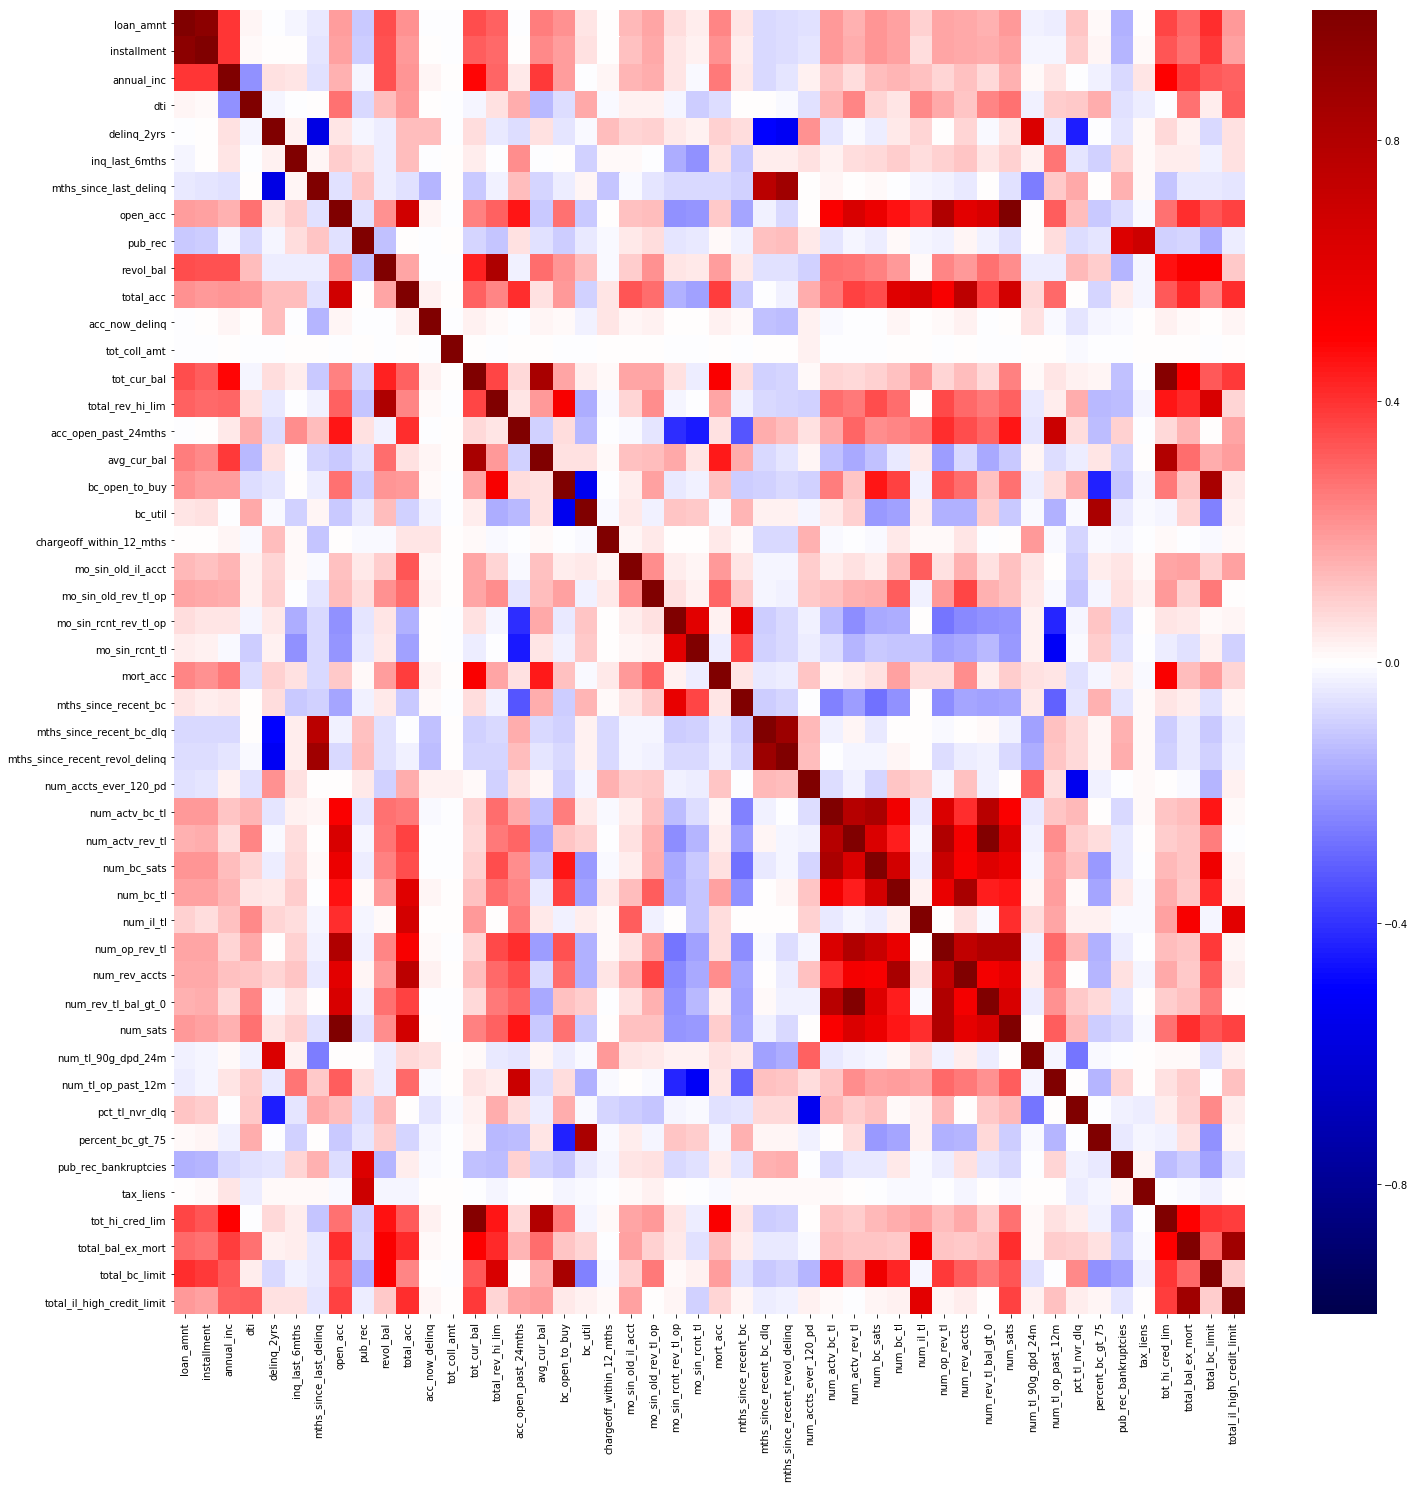

In [8]:

plt.figure(figsize=(24, 24))
sns.heatmap(df.corr(),vmin = -1, vmax = 1, cmap = 'seismic')

In [9]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
129420,24000.0,60 months,11.67%,529.88,B4,2 years,OWN,65000.0,Source Verified,Fully Paid,credit_card,AL,21.31,0.0,Aug-2003,2.0,34.0,19.0,0.0,11554.0,11.8%,29.0,0.0,0.0,91227.0,97900.0,7.0,5068.0,69409.0,11.6,0.0,123.0,130.0,8.0,8.0,2.0,8.0,NaN,34.0,0.0,4.0,8.0,10.0,11.0,6.0,16.0,21.0,8.0,19.0,0.0,1.0,93.1,0.0,0.0,0.0,260332.0,36642.0,78500.0,46332.0,Cash
29178,15000.0,36 months,12.39%,501.02,C1,4 years,OWN,35000.0,Source Verified,Fully Paid,debt_consolidation,AZ,11.76,0.0,Jan-2000,0.0,NaN,8.0,0.0,10361.0,58.9%,13.0,0.0,0.0,10361.0,17600.0,2.0,1295.0,471.0,94.9,0.0,177.0,117.0,16.0,16.0,0.0,31.0,NaN,NaN,0.0,4.0,7.0,4.0,7.0,2.0,8.0,11.0,7.0,8.0,0.0,0.0,100.0,75.0,0.0,0.0,17600.0,10361.0,9200.0,0.0,Cash
149680,35000.0,60 months,17.57%,880.61,D4,10+ years,RENT,155000.0,Verified,Charged Off,debt_consolidation,CA,6.94,0.0,Jul-1999,1.0,NaN,5.0,0.0,30335.0,92.8%,17.0,0.0,0.0,35254.0,32700.0,1.0,7051.0,2036.0,93.7,0.0,146.0,178.0,12.0,12.0,0.0,12.0,NaN,NaN,0.0,3.0,4.0,3.0,6.0,7.0,4.0,10.0,4.0,5.0,0.0,1.0,100.0,100.0,0.0,0.0,42081.0,35254.0,32200.0,9381.0,Cash
54552,30000.0,36 months,10.15%,970.13,B2,10+ years,MORTGAGE,140000.0,Verified,Fully Paid,credit_card,TX,22.00,1.0,Apr-2002,1.0,12.0,11.0,0.0,32382.0,66.4%,33.0,0.0,0.0,162330.0,48800.0,4.0,14757.0,8381.0,73.1,0.0,138.0,150.0,3.0,3.0,2.0,16.0,37.0,37.0,0.0,4.0,7.0,4.0,11.0,5.0,8.0,26.0,8.0,11.0,0.0,2.0,84.8,50.0,0.0,0.0,221505.0,53657.0,31100.0,38975.0,Cash
111397,13500.0,36 months,12.99%,454.81,C1,7 years,MORTGAGE,37500.0,Source Verified,Fully Paid,credit_card,MI,13.22,1.0,Apr-1996,3.0,16.0,10.0,0.0,11360.0,75.7%,24.0,0.0,225.0,66781.0,15000.0,4.0,7420.0,2622.0,74.3,0.0,143.0,219.0,3.0,3.0,3.0,3.0,NaN,NaN,2.0,4.0,7.0,6.0,14.0,2.0,9.0,19.0,7.0,10.0,0.0,2.0,83.3,60.0,0.0,0.0,85453.0,11360.0,10200.0,0.0,Cash


In [10]:
#df[df['num_tl_120dpd_2m'] >= 1][['num_tl_30dpd','num_tl_120dpd_2m','num_tl_90g_dpd_24m']]

In [11]:
# df[['int_rate','grade','sub_grade']].sort_values(by = 'int_rate')

# Clean Columns

In [12]:
def drop_percentage_signs(df, column_name):
    new_column_name = column_name + '_percent'
    df[new_column_name] = df[column_name].astype(str).str[:-1].astype(np.float64)
    return df.drop(columns = [column_name])

In [13]:
df.shape

(223102, 60)

In [14]:
#df['revol_util'].fillna('0%',inplace = True)
#df['revol_util'] =df['revol_util'].astype(str).str[:-1]


In [15]:
# Clean columns
# Convert loan terms into two categories 'short' and 'long'
df['term'] = df['term'].str.replace('36 months','short').str.replace('60 months','long').str.strip()

# Convert interest rate from percentage to float
df['int_rate'].dropna(axis = 0,how = 'any', inplace = True)
df=drop_percentage_signs(df,'int_rate')


# Fill Na's with 0.0% in revolving balance (unused revolving balance counts as NaN)
df['revol_util'].fillna(value = '0.0%',inplace = True)
df=drop_percentage_signs(df, 'revol_util')

In [16]:
df.shape

(223102, 60)

# Categorize 'Months Since' Variables

- First do a pd.cut() to bin the data into categories.
- Then fill nans as another category
- patsy.dmatrix does 'treatment' to do onehot encoding automatically on string columns


In [17]:
df['mths_since_last_delinq'] = \
pd.cut(df['mths_since_last_delinq'],5,labels =
       ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_bc'] = \
pd.cut(df['mths_since_recent_bc'],5,labels =
       ['0-10 years','10-20 years','20-30 years','30-40 years','40-50 years']
      ).cat.add_categories('never').fillna('never')# 

df['mths_since_recent_bc_dlq'] = \
pd.cut(df['mths_since_recent_bc_dlq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 

df['mths_since_recent_revol_delinq'] = \
pd.cut(df['mths_since_recent_revol_delinq'],5, labels = 
      ['0-3 years','3-6 years','6-9 years','9-12 years','12-15 years'
       ]).cat.add_categories('never').fillna('never') # 
df['mo_sin_old_il_acct'] = \
pd.cut(df['mo_sin_old_il_acct'],5).cat.add_categories('never').fillna('never')

In [18]:
def add_days_since_col(df,column_name):
    new_col_name = 'days_since_' + column_name
    df[new_col_name] = df[column_name].apply(lambda x: (dt.datetime.today().date() - 
                                                      dt.datetime.strptime(x,'%b-%Y').date()).days)
    return df.drop(columns = [column_name])

df = add_days_since_col(df,'earliest_cr_line')

# Last credit pulled has data leakage because credit is constantly pulled for non-defaulted loans. 
#df= df.dropna(subset = ['last_credit_pull_d'])
#df = add_days_since_col(df,'last_credit_pull_d')

# Patsy.dmatrix (pass string like last project, but no y~)

In [19]:
df.shape

(223102, 60)

In [47]:
# What NA Columns are we dropping
df.isnull().sum()[df.isnull().sum() != 0]
df_temp = df.dropna()

# Modeling

In [50]:
# Select a grade to look at 

# Only look at low grades, high interest
#df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('B' in element))]

df_temp.drop(columns = 'sub_grade', inplace = True)
# df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('D' in element) | ('E' in element))]

# Only look at good grades, low interest
# df_temp = df_temp.loc[df_temp['sub_grade'].apply(lambda element: ('A' in element) |
#                                                  ('B' in element) |
#                                                  ('C' in element))]

#Percentage of target
sum(df_temp['loan_status'] == 'Charged Off')/df_temp.shape[0]

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


0.18146612928672853

In [52]:
len(df_temp.columns)

59

In [73]:
df_temp.shape

(209163, 59)

In [53]:
# Convert target to binary,
df_temp['loan_status'] = df_temp['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
# Define a 'basic' dataframe that only predicts off LendingClub sub_grade feature
df_basic= df_temp[['loan_status','sub_grade']]
df_basic.shape

KeyError: "['sub_grade'] not in index"

In [55]:
def patsy_string_from_df(df):
    """Makes patsy string from dataframe df. Drops 'loan_status' variable by default."""
    df = df.drop(columns = ['loan_status']) # Drop the target variable, in this case it's loan_status
    patsy_string = ''
    for title in df.columns:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    # print("Patsy String: " +patsy_string)
    return patsy_string

In [56]:
# Make patsy design matrix from all dataframe 
# This takes care of onehot variables
X = patsy.dmatrix(patsy_string_from_df(df_temp),df_temp)
y = df_temp['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)

In [57]:
Xb = patsy.dmatrix(patsy_string_from_df(df_basic),df_basic)
yb = df_basic['loan_status'].values
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=123456)

# Models Tried

## Gridsearch for RandomForest

In [58]:
param_grid = {
    'bootstrap': [True],
#    'max_depth': [70, 90],
#    'max_features': ['sqrt'],
#    'min_samples_leaf': [1, 2],
#    'min_samples_split': [2, 3],
    'n_estimators': [200, 400]
}

#rf = RandomForestClassifier()
#rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
#rf_grid.fit(X_train, y_train)


In [59]:
model_dict = {'rfc': RandomForestClassifier(n_estimators = 400, n_jobs = -1,max_features = 'sqrt'),
             'lm' : LogisticRegression(max_iter =10000,solver='sag',verbose = 10,n_jobs = -1),
             'gnb' : GaussianNB(),
             'mlp' : MLPClassifier(verbose = 10),
             'gbc' : GradientBoostingClassifier(n_estimators =  1000, max_leaf_nodes = 4,\
                                                max_depth = None ,min_samples_split = 5, verbose = 10,
                                               learning_rate = .1)}

In [60]:
def make_model(mdl_key,X_train,y_train,X_test):
    """Uses key from model_dict and trains it on X_train, y_train, then returns \
    the model object used and predicted values on X_test"""
    assert (mdl_key in model_dict.keys()),"Model tag not in model_dict keys!"
    mdl = model_dict[mdl_key]
    mdl.fit(X_train,y_train)
    predicted = mdl.predict(X_test)
    return mdl, predicted

In [61]:
rfc, gnb_predicted = make_model('rfc',X_train,y_train,X_test)

In [62]:
lm, predicted = make_model('lm',X_train,y_train,X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 849 epochs took 200 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished


In [63]:
gnb, gnb_predicted = make_model('gnb',X_train,y_train,X_test)

In [64]:
mlp, mlp_predicted = make_model('mlp',X_train,y_train,X_test);

Iteration 1, loss = 6.35369164
Iteration 2, loss = 6.30175980
Iteration 3, loss = 6.25653347
Iteration 4, loss = 6.22936752
Iteration 5, loss = 6.25133544
Iteration 6, loss = 6.22468882
Iteration 7, loss = 6.14689926
Iteration 8, loss = 6.15396340
Iteration 9, loss = 6.18571380
Iteration 10, loss = 6.15591573
Iteration 11, loss = 6.08968429
Iteration 12, loss = 6.11505398
Iteration 13, loss = 6.11420686
Iteration 14, loss = 6.12923094
Iteration 15, loss = 6.04938552
Iteration 16, loss = 5.99023830
Iteration 17, loss = 6.08117050
Iteration 18, loss = 6.02849223
Iteration 19, loss = 5.99482820
Iteration 20, loss = 5.96344890
Iteration 21, loss = 5.91198742
Iteration 22, loss = 5.94293708
Iteration 23, loss = 6.02185770
Iteration 24, loss = 5.89996912
Iteration 25, loss = 5.90393203
Iteration 26, loss = 5.88312297
Iteration 27, loss = 5.90525325
Iteration 28, loss = 5.87613741
Iteration 29, loss = 5.88860450
Iteration 30, loss = 5.79970837
Iteration 31, loss = 5.83622197
Iteration 32, los

In [65]:
gbc, gbc_predicted = make_model('gbc',X_train,y_train,X_test)

In [66]:
# Fit random forest to basic model (sub_grade only)
rfc_b = RandomForestClassifier()
rfc_b.fit(Xb_train,yb_train)
predicted_b = rfc_b.predict(Xb_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<Figure size 480x320 with 0 Axes>

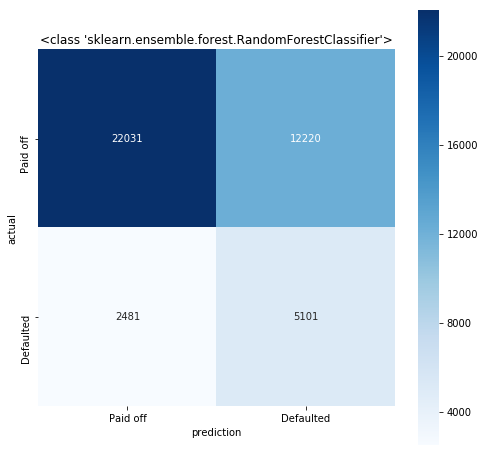

In [67]:
def make_confusion_matrix(model, threshold=.2):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    mat_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    plt.figure(figsize=(8, 8))
    sns.heatmap(mat_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid off', 'Defaulted'],
           yticklabels=['Paid off', 'Defaulted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title(str(type(model)))
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
make_confusion_matrix(rfc)



# Models to display 

In [72]:
df_temp['']

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


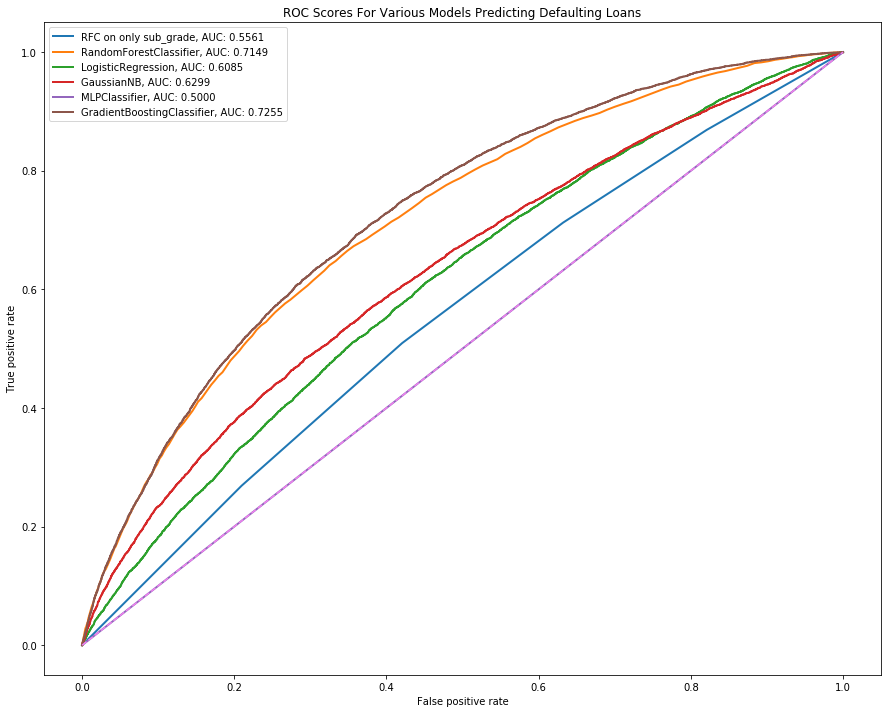

In [68]:
models=[rfc,lm,gnb,mlp, gbc]
plt.figure(figsize=(15, 12))
fpr_b,tpr_b,thresholds = roc_curve(yb_test, rfc_b.predict_proba(Xb_test)[:,1])

plt.plot(fpr_b,tpr_b,lw=2, label = 'RFC on only sub_grade' +\
        ', AUC: ' + str(roc_auc_score(yb_test, rfc_b.predict_proba(Xb_test)[:,1]))[:6])
def plot_models():
    ''' Plots all models in the models list defined above. Also plots a dotted line\
    representing the curve of a random model.'''
    model_info=list()
    for model in models:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        f1 = f1_score(y_test,model.predict(X_test))
        model_info.append((model, auc_score,f1))
        plt.plot(fpr, tpr,lw=2, label = str(model)[:str(model).find('(')] + ', AUC: ' + str(auc_score)[:6])
    
    #Random guess line
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc='upper left')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Scores For Various Models Predicting Defaulting Loans');
    return model_info
test = plot_models()



        

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic score: 0.8182


<Figure size 480x320 with 0 Axes>

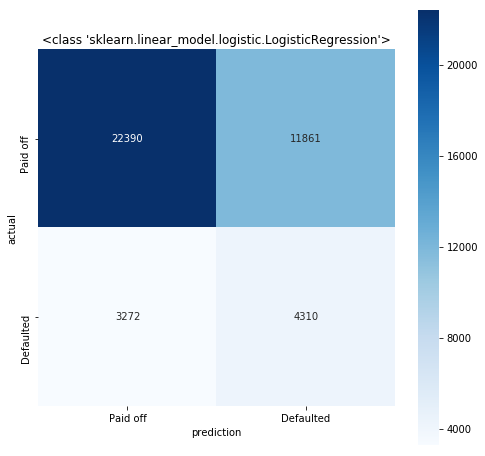

In [69]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456)
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,y_train)))

make_confusion_matrix(lm)

In [70]:
Xb_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0.],
       ...,
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.]])

# Write a COST FUNCTION
(Loans classified as defaulted but fully paid off * average paid off loan amount ) - 
(loans classified as paid off but defaulted * average loss to defaulted loan amount)